## Capstone 3 - Rossmann Store Sales Prediction

Rossmann operates over 3,000 drug stores in 7 European countries. The Objectives of this project is to analyze Rossmann's store profile and sales data, build a model to predict their daily sales for up to six weeks in advance. 

In [ ]:
!pip install shap

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas.testing as tm
from pandas.plotting import autocorrelation_plot

import statsmodels.api as sm
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from math import sqrt
from sklearn.linear_model import LinearRegression, LassoLars, BayesianRidge
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost.sklearn import XGBRegressor # wrapper
import shap

sns.set_style("whitegrid")

In [86]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [87]:
#! pip install -q kaggle

In [88]:
#import os
#os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/Colab Notebooks/Springboard - Data Science Career Track/24.4 - Capstone 3 - Rossmann Store Sales'

#changing the working directory 
#%cd /content/drive/MyDrive/Colab Notebooks/Springboard - Data Science Career Track/24.4 - Capstone 3 - Rossmann Store Sales

# Kaggle API command for the dataset
#! kaggle competitions download -c rossmann-store-sales

In [89]:
#check content in the directory
#!ls

In [90]:
#unzipping the zip files and deleting the zip files
#!unzip \*.zip  && rm *.zip

## 0) Loading the Dataset

In [91]:
#url to each dataset
store_raw = '/content/drive/MyDrive/Colab Notebooks/Springboard - Data Science Career Track/24.4 - Capstone 3 - Rossmann Store Sales/store.csv'
test_raw = '/content/drive/MyDrive/Colab Notebooks/Springboard - Data Science Career Track/24.4 - Capstone 3 - Rossmann Store Sales/test.csv'
train_raw = '/content/drive/MyDrive/Colab Notebooks/Springboard - Data Science Career Track/24.4 - Capstone 3 - Rossmann Store Sales/train.csv'

In [92]:
# loading the data 
store = pd.read_csv(store_raw, low_memory=False)
train = pd.read_csv(train_raw, parse_dates=['Date'], low_memory=False)
test = pd.read_csv(test_raw, low_memory=False)

In [93]:
# examining the store dataset
print("length/ features :", store.shape)
store.head()

length/ features : (1115, 10)


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [94]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [95]:
# examining the training dataset
print("length/ features :", train.shape)
train.head()

length/ features : (1017209, 9)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [96]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Store          1017209 non-null  int64         
 1   DayOfWeek      1017209 non-null  int64         
 2   Date           1017209 non-null  datetime64[ns]
 3   Sales          1017209 non-null  int64         
 4   Customers      1017209 non-null  int64         
 5   Open           1017209 non-null  int64         
 6   Promo          1017209 non-null  int64         
 7   StateHoliday   1017209 non-null  object        
 8   SchoolHoliday  1017209 non-null  int64         
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 69.8+ MB


# 1) Understanding the Data & Data Cleaning

In [97]:
# examining missing data
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

Missing data are all in relation to competition profile and promotion profile. Given no conclusion to whether competition is a factor affecting sales, and a store may not run a promotion, these data are retained at the moment. 

In [98]:
train.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [99]:
# understanding if the store and train dataframe can potentially be matched up
print('Min/ Max of Store in store dataset :',store['Store'].min(), '/', store['Store'].max())
print('Min/ Max of Store in train dataset :', train['Store'].min(), '/', train['Store'].max())

Min/ Max of Store in store dataset : 1 / 1115
Min/ Max of Store in train dataset : 1 / 1115


1.1) Merging the Store and Train Datasets

In [100]:
dfall = train.merge(store, left_on='Store', right_on='Store')
print("length/ features :", dfall.shape)
dfall.head()

length/ features : (1017209, 18)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,1,4,2015-07-30,5020,546,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2,1,3,2015-07-29,4782,523,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,1,2,2015-07-28,5011,560,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
4,1,1,2015-07-27,6102,612,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN


1.2) Checking for Inconsistent Data

In [101]:
#understanding if a sales transaction is really in a promotional period
#true promo is defined as 'Promo2' = True and the 'Promo2SinceYear' not larger than sales transaction year

dfall['Year'] = dfall['Date'].dt.year.astype(int)
dfall['True Promo'] = dfall.apply(lambda x: 1 if ((x['Promo2']==1) & (x['Promo2SinceYear'] <= x['Year'])) else 0, axis=1)

In [102]:
#Sales Recorded in a Store Closed day
sales_at_closeday = dfall[(dfall['Open']==0) & (dfall['Sales']!=0)]
sales_at_closeday

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,True Promo


In [103]:
#checking for duplicate records
duplicated = dfall[dfall.duplicated()]
duplicated

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,True Promo


# 2) Exploratory Data Analysis (EDA) & Visualization




2.1 Understanding Rossmann Store's Sales Data

In [104]:
#understanding the sales data timeframe
print('The sales data has a date range between:', dfall['Date'].min(), '&', dfall['Date'].max())

The sales data has a date range between: 2013-01-01 00:00:00 & 2015-07-31 00:00:00


Text(0, 0.5, 'Store Count (Aggregated)')

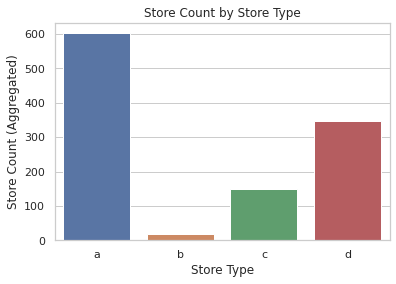

In [105]:
#count of store type
storecount = pd.pivot_table(store,index=['StoreType'],values=['Store'],aggfunc='size').reset_index()
sns.barplot(x='StoreType', y=0, data=storecount)
plt.title('Store Count by Store Type')
plt.xlabel('Store Type')
plt.ylabel('Store Count (Aggregated)')

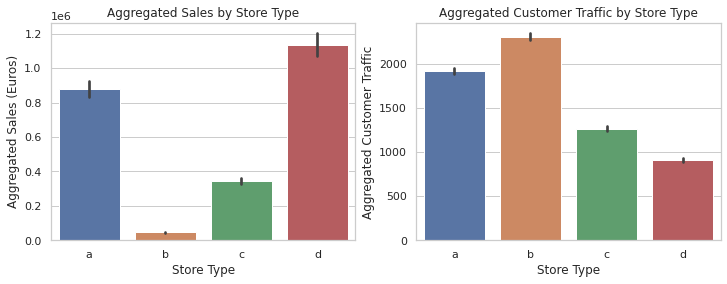

In [106]:
#distribution of store types
storetype = pd.pivot_table(dfall,index=['StoreType', 'Customers'],values=['Sales'],aggfunc=sum).reset_index()

fig, (ax1, ax2) =plt.subplots(1,2, figsize=(12,4))

# Aggregated Sales by store type
sns.barplot(data=storetype, x='StoreType', y='Sales', ax=ax1)
ax1.set_title('Aggregated Sales by Store Type')
ax1.set_xlabel('Store Type')
ax1.set_ylabel('Aggregated Sales (Euros)')

# Aggregated Customer Traffic by store type
sns.barplot(data=storetype, x='StoreType', y='Customers', ax=ax2)
ax2.set_title('Aggregated Customer Traffic by Store Type')
ax2.set_xlabel('Store Type')
ax2.set_ylabel('Aggregated Customer Traffic')
fig.show()

By store type, most stores are either type A or D. The aggregated sales are largely reflective of the store type profiles. However, despite b type stores existed the least, they have driven most of the customer traffic.

Text(0, 0.5, 'Avg. Sales (Euros)')

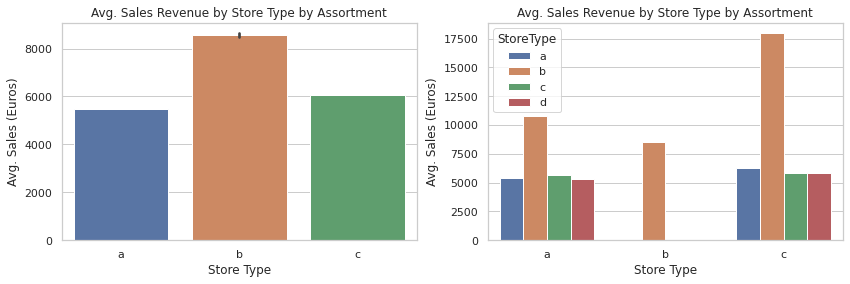

In [107]:
#average sales by store type & assortment
storetype_pivot = pd.pivot_table(dfall,index=['StoreType', 'Assortment'],values=['Sales'],aggfunc=np.mean).reset_index()
storetype_pivot['Sales'] = storetype_pivot['Sales'].round(2)

#creating subplots & order lists
fig, (ax1, ax2) =plt.subplots(1,2, figsize=(14,4))
order_list = ['a', 'b', 'c']

# Total Sales by assortment type
sns.barplot(x='Assortment', y='Sales', data=dfall, order=order_list, ax=ax1)
ax1.set_title('Avg. Sales Revenue by Store Type by Assortment')
ax1.set_xlabel('Store Type')
ax1.set_ylabel('Avg. Sales (Euros)')

# Average sales by assortment & store type
sns.barplot(x='Assortment', y='Sales', hue='StoreType', data=storetype_pivot, order=order_list, ax=ax2)
ax2.set_title('Avg. Sales Revenue by Store Type by Assortment')
ax2.set_xlabel('Store Type')
ax2.set_ylabel('Avg. Sales (Euros)')

A further deep diving into what type of assortment store type B (with most traffic carries), it is the extended assortment with a much wider range. Stores with extended assortment is also driving more sales on average.

In [108]:
#understanding the average value a customer brings
dfall['ATV'] = dfall['Sales']/dfall['Customers']
print('On average, a customer is spending', "%.2f" %(dfall['ATV'].mean()), 'euros per transaction.')

On average, a customer is spending 9.49 euros per transaction.


Text(0, 0.5, 'ATV (Euros)')

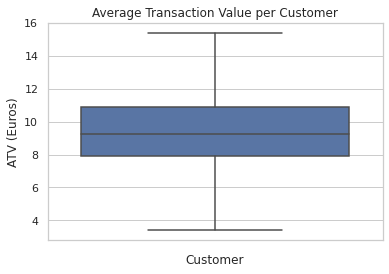

In [109]:
#boxplotting thes sales data per store type
sns.boxplot(y=dfall['ATV'], showfliers = False)
plt.title('Average Transaction Value per Customer')
plt.xlabel('Customer')
plt.ylabel('ATV (Euros)')

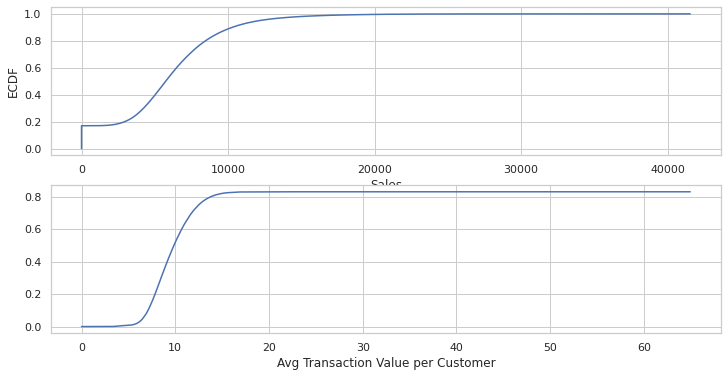

In [110]:
#ECDF diagram for Sales & ATV
plt.figure(figsize = (12, 6))

# plot first ECDF - Sales Figures
plt.subplot(211)
cdf = ECDF(dfall['Sales'])
plt.plot(cdf.x, cdf.y, label = "statmodels");
plt.xlabel('Sales'); plt.ylabel('ECDF');

# plot second ECDF - ATV figures 
plt.subplot(212)
cdf = ECDF(dfall['ATV'])
plt.plot(cdf.x, cdf.y, label = "statmodels");
plt.xlabel('Avg Transaction Value per Customer');

The ECDF plot indicated that around 20% of Sales data are showing zero in value. Store opening patterns will be examined to understand if this is due to stores not in operation.

In [111]:
#Days with store open but with zero sales value
zero_open = dfall[(dfall['Open']==1) & (dfall['Sales']==0)]
print('There are only', zero_open.shape[0], 'records which a store generated zero sales during an opened day.')
print('Accounting to only', "%.2f" %(zero_open.shape[0]/dfall.shape[0]*100), '% of total transaction records, and is negligable.')

There are only 54 records which a store generated zero sales during an opened day.
Accounting to only 0.01 % of total transaction records, and is negligable.


Text(0.5, 1.0, 'Rossmann Store Operating Pattern (Operating)')

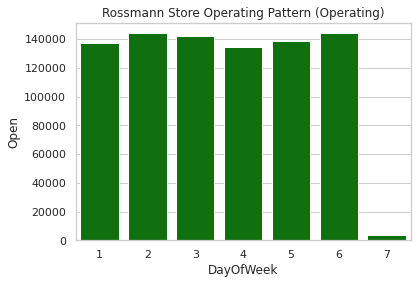

In [112]:
#undertanding store opening pattern
storeopen = pd.pivot_table(dfall,index=['DayOfWeek'],values=['Open'],aggfunc=np.sum).reset_index()
sns.barplot(x='DayOfWeek', y='Open', data=storeopen, color='green')
plt.title('Rossmann Store Operating Pattern (Operating)')

Most stores are not opened on Sundays.

2.2 Understanding If there are Seasonalities to Sales

Text(0.5, 1.0, 'Sales Trend - 2013 to 2015')

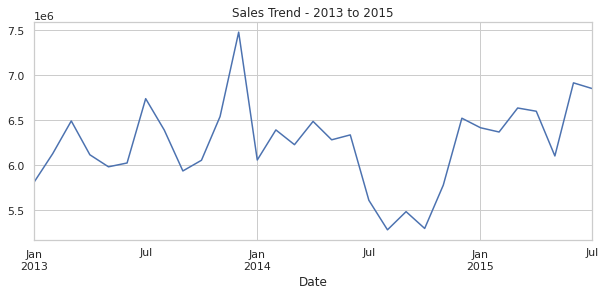

In [113]:
sales_trend = dfall.groupby('Date')['Sales'].sum().reset_index()
sales_trend = sales_trend.set_index('Date')

t = sales_trend['Sales'].resample('MS').mean()
t.plot(figsize=(10, 4))
plt.title('Sales Trend - 2013 to 2015')

The graph indicated that sales did not exponentially grow over the period. 

To further examine the sales trend across different store types, we have randomly selected a store from each store type to examine its' sales pattern.

In [114]:
#randomly select sample from each store type
random_a = dfall[dfall['StoreType'] == 'a'].sample(1)
random_b = dfall[dfall['StoreType'] == 'b'].sample(1)
random_c = dfall[dfall['StoreType'] == 'c'].sample(1)
random_d = dfall[dfall['StoreType'] == 'd'].sample(1)

# retrieving the store number
a = random_a.iloc[0]['Store']
b = random_b.iloc[0]['Store']
c = random_c.iloc[0]['Store']
d = random_d.iloc[0]['Store']

print('Randomied Store number sampled for each store type (a to d):', a, b, c, d)

Randomied Store number sampled for each store type (a to d): 105 769 327 669


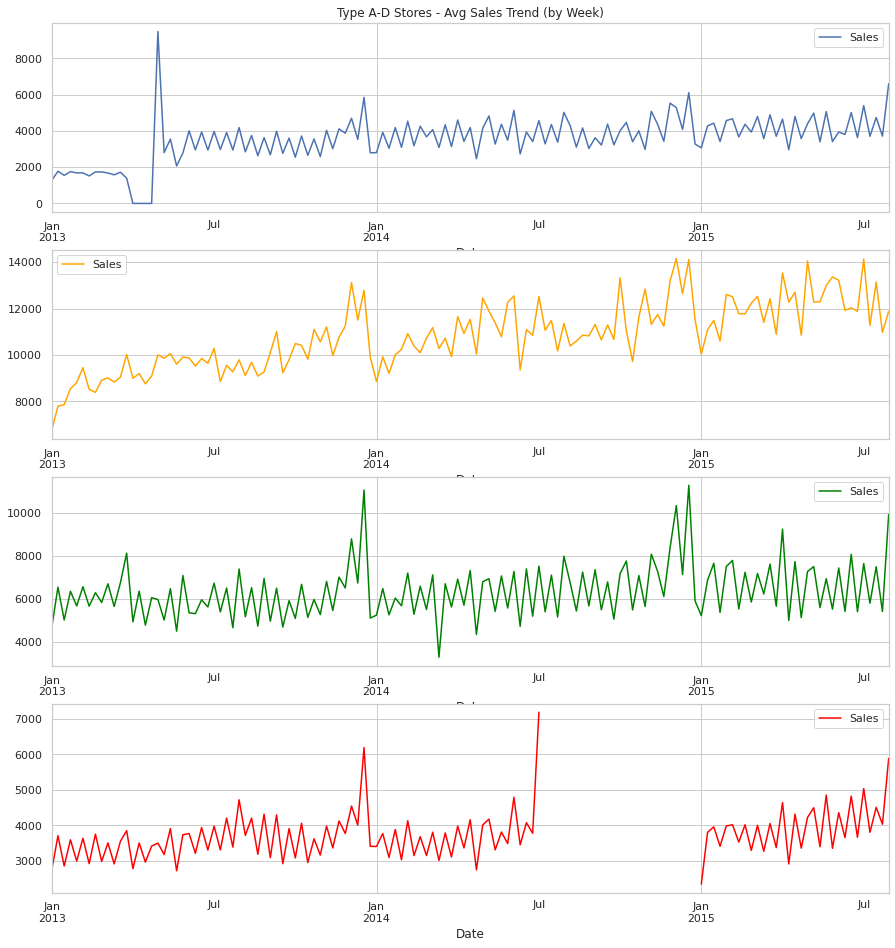

In [115]:
type_a = dfall[dfall['Store'] == a][['Date','Sales']].set_index('Date')
type_b = dfall[dfall['Store'] == b][['Date','Sales']].set_index('Date')
type_c = dfall[dfall['Store'] == c][['Date','Sales']].set_index('Date')
type_d = dfall[dfall['Store'] == d][['Date','Sales']].set_index('Date')

# plotting the seasonality sales trend of the stores by type
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (15, 16))
type_a.resample('W').mean().plot(ax=ax1)
ax1.title.set_text('Type A-D Stores - Avg Sales Trend (by Week)')
type_b.resample('W').mean().plot(ax=ax2, color='orange')
type_c.resample('W').mean().plot(ax=ax3, color='green')
type_d.resample('W').mean().plot(ax=ax4, color='red')

With the exception of Store Type B, all other store types has distinct pattern where sales peaked in Dec, coinciding with the holiday seasons.

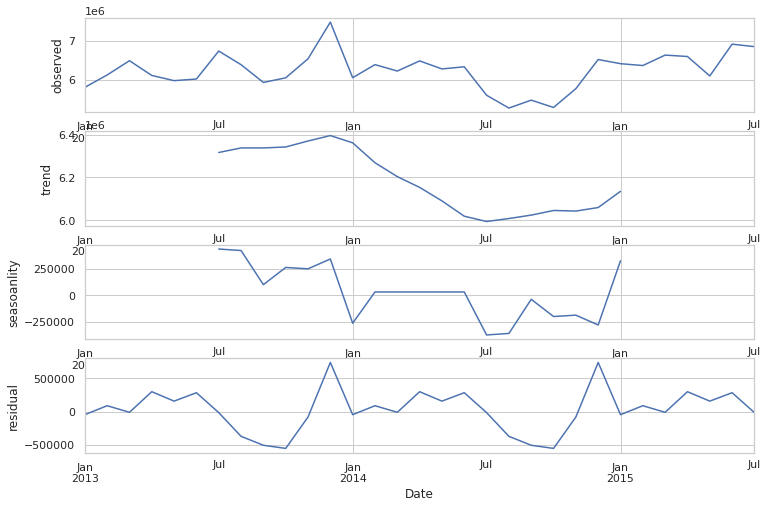

In [116]:
# additive instead of multiplicative is chosen as the model since no exponential increase in sales over time
sea_dec = seasonal_decompose(t, model = "additive")

fig, (ax1, ax2, ax3,ax4) = plt.subplots(4,1, figsize=(12,8))
sea_dec.observed.plot(ax=ax1,ylabel = "observed")
sea_dec.trend.plot(ax=ax2,ylabel = "trend")
sea_dec.resid.plot(ax=ax3,ylabel = "seasoanlity")
sea_dec.seasonal.plot(ax=ax4,ylabel = "residual")
plt.show()

2.3 Understanding Factors driving Store Sales

Text(0.5, 1.0, 'Relationship between Customer Traffic and Sales')

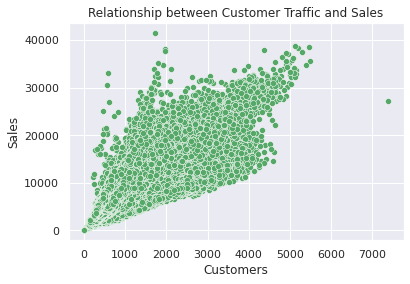

In [117]:
# Relationship between number of customer traffic and sales
sns.set_theme(color_codes=True)
sns.scatterplot(x='Customers', y='Sales', data=dfall, color='g') #regplot for fit line
plt.title('Relationship between Customer Traffic and Sales')

There is a clear pattern that customer traffic is correlated to sales.

Text(0, 0.5, 'Avg Sales')

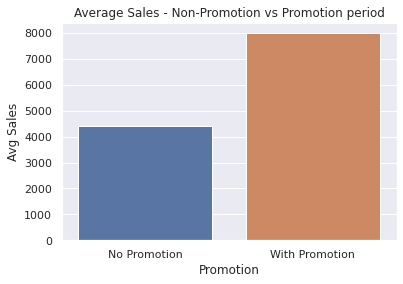

In [118]:
#understanding the impact of promotion to sales
promo_pivot = pd.pivot_table(dfall,index=['Promo'],values=['Sales'],aggfunc=np.mean).reset_index()
promo_pivot['Sales'] = promo_pivot['Sales'].round(2)
promo_pivot['Promo'] = promo_pivot['Promo'].replace({0: 'No Promotion', 1: 'With Promotion'})
sns.barplot(x='Promo', y='Sales', data=promo_pivot) #regplot for fit line
plt.title('Average Sales - Non-Promotion vs Promotion period')
plt.xlabel('Promotion')
plt.ylabel('Avg Sales')

In [119]:
#averge extra sales generated vs non-promotional period
print('On average, average sales value is', "%.2f" %(promo_pivot['Sales'].pct_change()[1]*100), '% more if there is a promotion.')

On average, average sales value is 81.37 % more if there is a promotion.


Text(0, 0.5, 'Avg Customer Traffic')

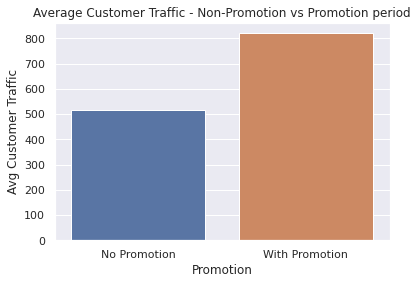

In [120]:
#Are promotions driving customer traffic
promotraffic = pd.pivot_table(dfall,index=['Promo'],values=['Customers'],aggfunc=np.mean).reset_index()
promotraffic['Customers'] = promotraffic['Customers'].round(2)
promotraffic['Promo'] = promotraffic['Promo'].replace({0: 'No Promotion', 1: 'With Promotion'})
sns.barplot(x='Promo', y='Customers', data=promotraffic) #regplot for fit line
plt.title('Average Customer Traffic - Non-Promotion vs Promotion period')
plt.xlabel('Promotion')
plt.ylabel('Avg Customer Traffic')

In [121]:
#averge extra traffic generated vs non-promotional period
print('On average, average customer traffic is', "%.2f" %(promotraffic['Customers'].pct_change()[1]*100), '% more if there is a promotion.')

On average, average customer traffic is 58.38 % more if there is a promotion.


Text(0, 0.5, 'Sales (Euros)')

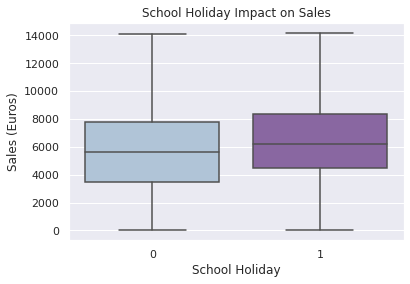

In [122]:
#Understanding the impact on sales on school holidays
sns.boxplot(x='SchoolHoliday', y='Sales', data=dfall, showfliers = False, palette='BuPu')
plt.title('School Holiday Impact on Sales')
plt.xlabel('School Holiday')
plt.ylabel('Sales (Euros)')

Text(0, 0.5, 'Sales (Euros)')

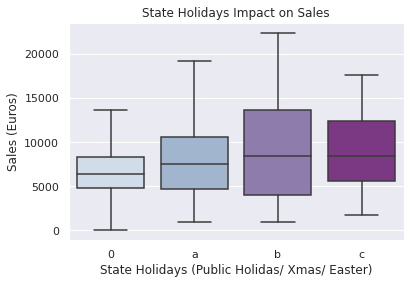

In [123]:
openstatehol = dfall[(dfall['Open']==1) & (dfall['StateHoliday']!=0)]
sns.boxplot(x='StateHoliday', y='Sales', data=openstatehol, showfliers = False, palette='BuPu')
plt.title('State Holidays Impact on Sales')
plt.xlabel('State Holidays (Public Holidas/ Xmas/ Easter)')
plt.ylabel('Sales (Euros)')

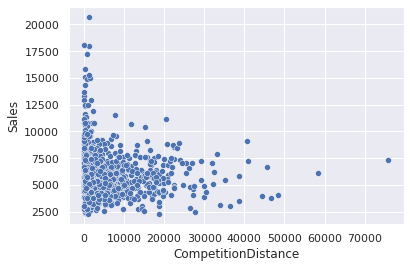

In [124]:
#impact of competition to sales
competition = dfall[dfall['CompetitionDistance'].notnull()]
comp_pivot = pd.pivot_table(competition, index=['Store', 'CompetitionDistance'],values=['Sales'],aggfunc=np.mean).reset_index()
sns.scatterplot(x='CompetitionDistance', y='Sales', data=comp_pivot)

There is no clear pattern how competition is affecting sales.

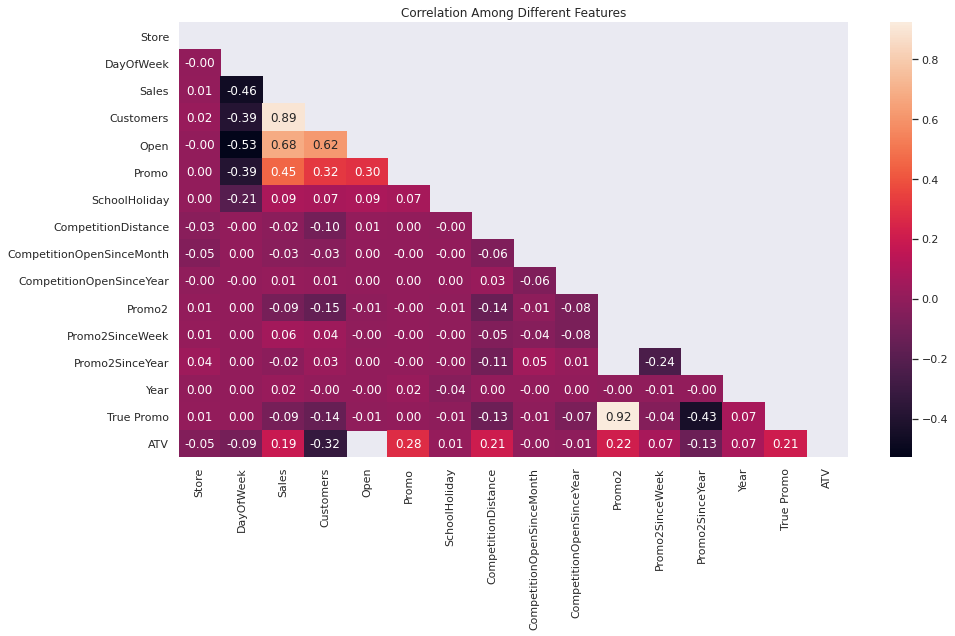

In [125]:
#understanding the correlation between the features
matrix = np.triu(dfall.corr())
plt.figure(figsize=(15,8))
plt.title('Correlation Among Different Features')
sns.heatmap(dfall.corr(), annot=True, mask=matrix, fmt=".2f")

# 3) Pre-Processing




In [126]:
# current dataframe
dfall.shape

(1017209, 21)

3.1) Extracting Additional Features from Dataset

Since dates will eventually be dropped, features from current date-time data needs to be extracted.

In [127]:
dfall['Month of Year'] = dfall['Date'].dt.month.astype(int)
dfall['Day of Month'] = dfall['Date'].dt.day.astype(int)
dfall['Week of Year'] = dfall['Date'].dt.isocalendar().week.astype(int)

3.2) Feature Engineering

In [128]:
#average sales per day by store type
avgsalbytype = dfall.groupby(['StoreType', 'Date'])['Sales'].mean().reset_index()
avgsalbytype.rename(columns={'Sales' : 'Avg Sales by StoreType'}, inplace=True)
avgsalbytype.head(3)

,StoreType,Date,Avg Sales by StoreType
0,a,2013-01-01,4.836938
1,a,2013-01-02,6512.269103
2,a,2013-01-03,5860.509967


In [129]:
# time lagged features on average sales by store type
avgsalbytype['lag -7 by store type'] = avgsalbytype['Avg Sales by StoreType'].shift(-7)
avgsalbytype['lag +7 by store type'] = avgsalbytype['Avg Sales by StoreType'].shift(7)

# fill null values
avgsalbytype['lag -7 by store type'] = avgsalbytype['lag -7 by store type'].fillna(method='ffill')
avgsalbytype['lag +7 by store type'] = avgsalbytype['lag +7 by store type'].fillna(method='bfill')

In [130]:
#merge avg sales by store type to dataframe
dfall = dfall.merge(avgsalbytype, how='left', left_on=['StoreType', 'Date'], right_on=['StoreType', 'Date'])

3.3) Hot Coding Categorical Data Columns

In [131]:
# Columns which reqires hot coding
dfall.select_dtypes(include='object').columns

Index(['StateHoliday', 'StoreType', 'Assortment', 'PromoInterval'], dtype='object')

In [132]:
# cleaning the StateHoliday data to only contain string
dfall['StateHoliday'].replace(0,'0', inplace=True)
dfall['StateHoliday'].unique()

array(['0', 'a', 'b', 'c'], dtype=object)

In [133]:
# cleaning the PromoInterval data 
dfall['PromoInterval'].replace({',':'', np.nan:'0'} , inplace=True)
dfall['PromoInterval'].unique()

array(['0', 'Jan,Apr,Jul,Oct', 'Feb,May,Aug,Nov', 'Mar,Jun,Sept,Dec'],
      dtype=object)

In [134]:
# labelEncoding StateHoliday, StoreType, Assortment, PromoInterval
lbl = preprocessing.LabelEncoder()
dfall['StateHoliday'] = lbl.fit_transform(dfall['StateHoliday'].values)
dfall['StoreType'] = lbl.fit_transform(dfall['StoreType'].values)
dfall['Assortment'] = lbl.fit_transform(dfall['Assortment'].values)
dfall['PromoInterval'] = lbl.fit_transform(dfall['PromoInterval'].values)

In [135]:
#categorical data + date data
categorical_cols = ['StateHoliday', 'StoreType', 'DayOfWeek']

#onehotcoding
dfhotcode = dfall[['StateHoliday', 'StoreType', 'DayOfWeek']]  
dfhotcode = pd.get_dummies(dfhotcode, columns = categorical_cols)

In [136]:
#join dfall with onehotcoded dataframe, drop excess columns
df = dfall.merge(dfhotcode, left_index=True, right_index=True)
df = df.drop(categorical_cols, axis=1)

#drop unique identifier columns - Date and Store number
df = df.drop(['Store', 'Date'], axis=1)

In [137]:
df.head()

,Sales,Customers,Open,Promo,SchoolHoliday,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,True Promo,ATV,Month of Year,Day of Month,Week of Year,Avg Sales by StoreType,lag -7 by store type,lag +7 by store type,StateHoliday_0,StateHoliday_1,StateHoliday_2,StateHoliday_3,StoreType_0,StoreType_1,StoreType_2,StoreType_3,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7
0,5263,555,1,1,1,0,1270.0,9.0,2008.0,0,NaN,NaN,0,2015,0,9.482883,7,31,31,9109.317568,9235.364943,5667.641892,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0
1,5020,546,1,1,1,0,1270.0,9.0,2008.0,0,NaN,NaN,0,2015,0,9.194139,7,30,31,7862.202703,9.755747,5716.027027,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0
2,4782,523,1,1,1,0,1270.0,9.0,2008.0,0,NaN,NaN,0,2015,0,9.143403,7,29,31,7646.945946,5675.066092,5286.695946,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0
3,5011,560,1,1,1,0,1270.0,9.0,2008.0,0,NaN,NaN,0,2015,0,8.948214,7,28,31,8151.304054,5808.626437,5473.175676,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0
4,6102,612,1,1,1,0,1270.0,9.0,2008.0,0,NaN,NaN,0,2015,0,9.970588,7,27,31,9661.804054,5352.925287,6456.209459,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0


In [138]:
df.shape

(1017209, 37)

In [139]:
#dropping records where store is closed
drop_index = df[df['Open']==0].index
df = df.drop(drop_index)
print('after dropping records where stores are closed:', df.shape)

after dropping records where stores are closed: (844392, 37)


3.4) Handling Missing Data

In [140]:
#checking for missing data
nullcheck = df.isnull().sum().to_frame()
nullcheck[nullcheck[0] !=0]

,0
CompetitionDistance,2186
CompetitionOpenSinceMonth,268619
CompetitionOpenSinceYear,268619
Promo2SinceWeek,423307
Promo2SinceYear,423307
ATV,52


*   ATV - null values will be filled by 0 as the transaction records are also showing 0 sales
*   Competition Distance, OpenSince Month/ Year - will be hanelded using mean or median data
*   Promo2SinceWeek/ Promo2SinceYear Columns, as the other column Promo is already indicating whether the transaction was done with promotion, these 2 columns will eventually be dropped given half of them are missing


In [141]:
# fillna for ATV with 0
df['ATV'].replace(np.nan, 0, inplace=True)

# fillna with mean for Competition Distance, Open Since Month/ Year
df['CompetitionDistance'].replace(np.nan, df['CompetitionDistance'].mean(), inplace=True)
df['CompetitionOpenSinceMonth'].replace(np.nan, df['CompetitionOpenSinceMonth'].mean(), inplace=True)
df['CompetitionOpenSinceYear'].replace(np.nan, df['CompetitionOpenSinceYear'].mean(), inplace=True)

In [142]:
#drop Promo2SinceWeek/ Promo2SinceYear
df = df.drop(['Promo2SinceWeek', 'Promo2SinceYear'], axis=1)

3.5) Train/Test Split

In [143]:
#dropping target variable
features = df.drop(['Sales'], axis=1)

In [144]:
X = features
y = df['Sales']

In [145]:
# Train Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=1)

3.6) Removing Colinearity

In [146]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string

In [147]:
def iterate_vif(df, vif_threshold=5, max_vif=6):
  count = 0
  while max_vif > vif_threshold:
    count += 1
    print("Iteration # "+str(count))
    vif = pd.DataFrame()
    vif["VIFactor"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    vif["features"] = df.columns

    if vif['VIFactor'].max() > vif_threshold:
      print('Removing %s with VIF of %f' % (vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], vif['VIFactor'].max()))
      df = df.drop(vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], axis=1)
      max_vif = vif['VIFactor'].max()
    else:
      print('Complete')
      return df, vif.sort_values('VIFactor')

final_df, final_vif = iterate_vif(X_train)

Iteration # 1


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


Removing StateHoliday_0 with VIF of inf
Iteration # 2


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


Removing StoreType_0 with VIF of inf
Iteration # 3


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


Removing DayOfWeek_1 with VIF of inf
Iteration # 4
Removing Open with VIF of 8094369.055563
Iteration # 5
Removing Year with VIF of 166105.941615
Iteration # 6
Removing CompetitionOpenSinceYear with VIF of 128.168951
Iteration # 7
Removing Month of Year with VIF of 56.961367
Iteration # 8
Removing Avg Sales by StoreType with VIF of 48.430964
Iteration # 9
Removing ATV with VIF of 28.712515
Iteration # 10
Removing Promo2 with VIF of 24.855856
Iteration # 11
Removing lag -7 by store type with VIF of 13.747783
Iteration # 12
Removing lag +7 by store type with VIF of 9.986441
Iteration # 13
Removing CompetitionOpenSinceMonth with VIF of 6.307279
Iteration # 14
Removing True Promo with VIF of 5.599752
Iteration # 15
Complete


In [148]:
final_df.head()

,Customers,Promo,SchoolHoliday,Assortment,CompetitionDistance,PromoInterval,Day of Month,Week of Year,StateHoliday_1,StateHoliday_2,StateHoliday_3,StoreType_1,StoreType_2,StoreType_3,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7
227230,2206,0,1,2,340.0,0,21,30,0,0,0,0,0,0,1,0,0,0,0,0
306185,457,1,0,2,10600.0,1,20,8,0,0,0,0,0,1,0,0,0,1,0,0
129107,547,0,0,0,1090.0,0,26,9,0,0,0,0,0,0,1,0,0,0,0,0
608510,1168,1,0,0,1270.0,0,21,21,0,0,0,0,1,0,0,1,0,0,0,0
172240,673,1,0,0,1100.0,2,21,21,0,0,0,0,0,0,0,1,0,0,0,0


In [149]:
final_vif.sort_values(by='VIFactor', ascending=False)

,VIFactor,features
0,4.894174,Customers
6,3.720073,Day of Month
7,3.429644,Week of Year
1,2.206620,Promo
3,2.057989,Assortment
18,1.785979,DayOfWeek_6
5,1.780072,PromoInterval
14,1.722892,DayOfWeek_2
17,1.698110,DayOfWeek_5
15,1.695610,DayOfWeek_3


3.7) Building final features and Train/Test Split

In [150]:
final_features = final_df.columns.tolist()
final_features

['Customers',
 'Promo',
 'SchoolHoliday',
 'Assortment',
 'CompetitionDistance',
 'PromoInterval',
 'Day of Month',
 'Week of Year',
 'StateHoliday_1',
 'StateHoliday_2',
 'StateHoliday_3',
 'StoreType_1',
 'StoreType_2',
 'StoreType_3',
 'DayOfWeek_2',
 'DayOfWeek_3',
 'DayOfWeek_4',
 'DayOfWeek_5',
 'DayOfWeek_6',
 'DayOfWeek_7']

In [151]:
X = df[final_features]
y = df['Sales']

In [152]:
X.shape, y.shape

((844392, 20), (844392,))

In [153]:
# Train Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=1)

# 4) Modelling




4.1 )Several models will be used initially to test the effectiveness in the prediction:<br>


*   Linear Regression
*   Lasso Regression
*   Bayesian Ridge Regression
*   Random Forest Regressor
*   XGboost Regressor






In [154]:
#Linear Regression Model
lr = LinearRegression()
lr_model = lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

#Scores
lr_train = lr_model.score(X_train, y_train).round(3)
lr_test =  lr_model.score(X_test, y_test).round(3)
lr_rmse =  sqrt(mean_squared_error(y_test, y_pred))

In [155]:
#Linear Regression Results
print("Linear Regresion Model Score (Training)" , ":" , lr_train)
print("Linear Regresion Model Score (Testing)" , ":" , lr_test)
print("RMSE (Testing set)" , ":" , lr_rmse)

Linear Regresion Model Score (Training) : 0.82
Linear Regresion Model Score (Testing) : 0.819
RMSE (Testing set) : 1315.9271511431423


In [156]:
#Lasso Regression Model
lasr = LassoLars()
lasr_model = lasr.fit(X_train, y_train)
y_pred = lasr.predict(X_test)

#Scores
lasr_train = lasr_model.score(X_train, y_train).round(3)
lasr_test =  lasr_model.score(X_test, y_test).round(3)
lasr_rmse =  sqrt(mean_squared_error(y_test, y_pred))

In [157]:
#Lasso Regression Model Results
print("Lasso Regresion Model Score (Training)" , ":" , lasr_train)
print("Lasso Regresion Model Score (Testing)" , ":" , lasr_test)
print("RMSE (Testing set)" , ":" , lasr_rmse)

Lasso Regresion Model Score (Training) : 0.617
Lasso Regresion Model Score (Testing) : 0.614
RMSE (Testing set) : 1921.055954071017


In [158]:
#Bayesian Ridge Regression Model
brr = BayesianRidge()
brr_model = brr.fit(X_train, y_train)
y_pred = brr.predict(X_test)

#Scores
brr_train = brr_model.score(X_train, y_train).round(3)
brr_test =  brr_model.score(X_test, y_test).round(3)
brr_rmse =  sqrt(mean_squared_error(y_test, y_pred))

In [159]:
#Bayesian Ridge Regression Results
print("Bayesian Ridge Regression Model Score (Training)" , ":" , brr_train)
print("Bayesian Ridge Regression Model Score (Testing)" , ":" , brr_test)
print("RMSE (Testing set)" , ":" , brr_rmse)

Bayesian Ridge Regression Model Score (Training) : 0.82
Bayesian Ridge Regression Model Score (Testing) : 0.819
RMSE (Testing set) : 1315.9289761200425


In [160]:
#Random Forest Regressor Model
rfr = RandomForestRegressor(n_estimators=5)
rfr_model = rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)

#Scores
rfr_train = rfr_model.score(X_train, y_train).round(3)
rfr_test =  rfr_model.score(X_test, y_test).round(3)
rfr_rmse =  sqrt(mean_squared_error(y_test, y_pred))

In [161]:
#Random Forest Regressor Results
print("Random Forest Regressor Model Score (Training)" , ":" , rfr_train)
print("Random Forest Regressor Model Score (Testing)" , ":" , rfr_test)
print("RMSE (Testing set)" , ":" , rfr_rmse)

Random Forest Regressor Model Score (Training) : 0.991
Random Forest Regressor Model Score (Testing) : 0.958
RMSE (Testing set) : 635.0858227969944


This model's result is indicating an overfitting issue.

In [162]:
#XGBoost Regressor Model
xgb = XGBRegressor(silent=True)
xgb_model = xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

#Scores
xgb_train = xgb_model.score(X_train, y_train).round(3)
xgb_test =  xgb_model.score(X_test, y_test).round(3)
xgb_rmse =  sqrt(mean_squared_error(y_test, y_pred))

In [163]:
#XGBoost Regressor Model
print("XGBoost Regressor Model Score (Training)" , ":" , xgb_train)
print("XGBoost Regresso Model Score (Testing)" , ":" , xgb_test)
print("RMSE (Testing set)" , ":" , xgb_rmse)

XGBoost Regressor Model Score (Training) : 0.882
XGBoost Regresso Model Score (Testing) : 0.881
RMSE (Testing set) : 1067.643874769758


4.2) Initial Results from Various Models

In [164]:
model_comp = pd.DataFrame({'Metrics/ Model': ['Accuracy Score (Train data)', 'Accuracy Score (Test data)', 'RMSE (Test data)'],
                           'Linear Regression': [lr_train, lr_test, lr_rmse],
                           'Lasso Regression': [lasr_train, lasr_test, lasr_rmse],
                           'Bayesian Ridge Regression Model': [brr_train, brr_test, brr_rmse],
                           'Random Forest Regressor Model': [rfr_train, rfr_test, rfr_rmse],
                           'XGBoost': [xgb_train, xgb_test, xgb_rmse],
                          }).round(3)

In [165]:
model_comp

,Metrics/ Model,Linear Regression,Lasso Regression,Bayesian Ridge Regression Model,Random Forest Regressor Model,XGBoost
0,Accuracy Score (Train data),0.820,0.617,0.820,0.991,0.882
1,Accuracy Score (Test data),0.819,0.614,0.819,0.958,0.881
2,RMSE (Test data),1315.927,1921.056,1315.929,635.086,1067.644


Among all the models tested, XGBoost Regressor yields the best accuracy with minimal RMSE scores. Random Forest Regressor Model is not selected as based on the score, the model is over-fitting. Further parameters tunning will be attempted to refine the model.<br>

# 5) Model Evaluation and Optimization




In [166]:
from sklearn import model_selection, metrics
from sklearn.model_selection import cross_val_score

In [167]:
cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=5)
print("Mean cross-validation score (Pre-Optimized Model): %.2f" % cv_scores.mean())

Mean cross-validation score (Pre-Optimized Model): 0.88


In [168]:
# the same parameters as for xgboost model
params_xgb1 = {'max_depth': 10, 
            'n_estimators': 50,
            'objective': 'reg:linear',  
            'learning_rate': 0.1, 
              }     

xgb1 = XGBRegressor(**params_xgb1)

xgb1.fit(X_train, y_train)

[13:28:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=50,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [170]:
params_grid = {  
    'learning_rate': [0.01, 0.1],
    'max_depth': [1, 5],
    'gamma': [1, 3, 5]
              }

search_xgb = RandomizedSearchCV(xgb1, params_grid, cv = 3, n_jobs=-1) 
search_xgb.fit(X_train, y_train)

# best parameters
print(search_xgb.best_params_); print(search_xgb.best_score_)

[13:45:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'max_depth': 5, 'learning_rate': 0.1, 'gamma': 5}
0.8923015609938784


5.1) Re-running the model with improved parameters

In [171]:
#XGBoost Classifier (optimized parameters)
xgb_opt = XGBRegressor(learning_rate=0.1, max_depth=5, gamma=5, silent=True)
xgb_model_opt = xgb_opt.fit(X_train, y_train)
y_pred = xgb_model_opt.predict(X_test)

In [172]:
#XGBoost Scores (optimized parameters)
xgb_opt_train = xgb_model_opt.score(X_train, y_train).round(3)
xgb_opt_test =  xgb_model_opt.score(X_test, y_test).round(3)
xgb_opt_rmse =  sqrt(mean_squared_error(y_test, y_pred))

print('Optimized XGB Regressor Model Score (Training):', xgb_opt_train)
print('Optimized XGB Regressor Model Score (Testing):', xgb_opt_test)
print('RMSE (Testing)):', xgb_opt_rmse)

Optimized XGB Regressor Model Score (Training): 0.91
Optimized XGB Regressor Model Score (Testing): 0.909
RMSE (Testing)): 935.4620534558957


In [173]:
cv_scores = cross_val_score(xgb_model_opt, X_train, y_train, cv=5)
print("Mean cross-validation score (optimized model): %.2f" % cv_scores.mean())

Mean cross-validation score (optimized model): 0.91


5.2) Understanding Feature Importance and Shap Analysis

In [174]:
labels = final_df.columns.tolist()
imp_feat_score = xgb_model_opt.feature_importances_
comb_list = list(zip(labels, imp_feat_score))

feat_rank = pd.DataFrame(comb_list,columns=['labels', 'imp_feat_score']).sort_values(by='imp_feat_score', ascending=False)

Text(0.5, 1.0, 'Feature importance of the final model')

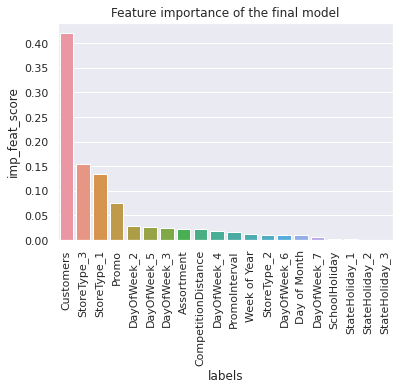

In [175]:
sns.barplot(x='labels', y='imp_feat_score', data=feat_rank)
plt.xticks(rotation=90)
plt.title('Feature importance of the final model')

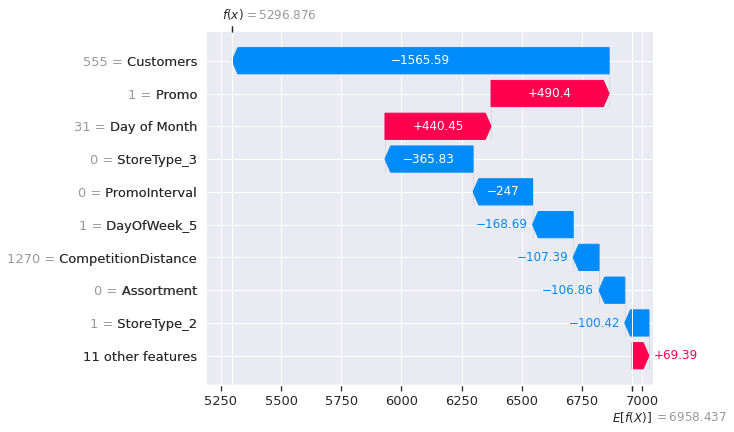

In [176]:
# explain the model's predictions using SHAP
explainer = shap.Explainer(xgb_model_opt)
shap_values = explainer(X)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

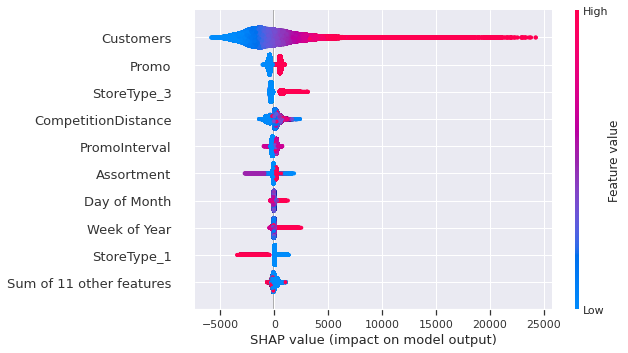

In [177]:
shap.plots.beeswarm(shap_values)

# 6) Conclusion




Several models were analyzed in order to predict Rossmann Store's sales. Models analyzed:<br>
*   Linear Regression
*   Lasso Regression
*   Bayesian Ridge Regression
*   Random Forest Regressor
*   XGBoost Regressor
<br>
These models were applied towards 1115 of Rossmann's store sales data, recorded between 2013 to 2015. The model's predictive results were evaluated based on the least residual mean squared error. <br>
Among all models used for prediction, XGBoost Regressor (with parameters - max_depth = 5, gamma = 5, learning_rate = 0.1 ) yields the best scores. The optimized model's acruacy score of 0.909 and lowest RMSE of 935.46. The model yield a cross validation score of 0.91.<br>
Whether the store is in promotion and the day of month is most significantly a predictive factor to the store's sales.


*Limitations to the Model/ Further Considerations:*<br>
*   The model assumed the business environment stayed largely similar over the period e.g. business model, key competitors. It also assumed the 1115 stores is a good representation of the sales pattern for the other Rossmann stores.
*   Current model is built only based on the most important features, either retrieved or engineered using the training and store data. In subsequent phases, other internal customer profiling data external or competitor data could be introduced to further improve the model's predictibility.  



